In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pint import UnitRegistry
import pandas as pd
ureg = UnitRegistry(autoconvert_offset_to_baseunit=True)
Q_ = ureg.Quantity

In [55]:
data = xr.open_dataset("./temp/trace_test4.nc")
data

<xarray.Dataset> Size: 122kB
Dimensions:     (Wavelength: 5100)
Coordinates:
  * Wavelength  (Wavelength) float64 41kB 1.5e+03 1.5e+03 ... 1.6e+03 1.6e+03
Data variables:
    Trace 0     (Wavelength) float64 41kB ...
    Trace 1     (Wavelength) float64 41kB ...
Attributes: (12/14)
    units:             dBm
    notes:             
    date:              2024-09-12 17:45:23
    start:             1500.0
    start_units:       nm
    stop:              1600.0
    ...                ...
    resolution_units:  nm
    reference:         0.0
    reference_units:   dBm
    trace_points:      5001
    sensitivity:       SNHD
    trace:             A

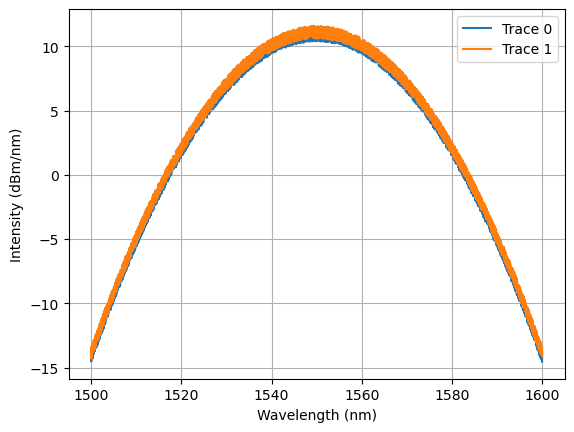

In [51]:
fig, ax = plt.subplots()
if data.attrs['units'] == 'dBm' and data['Wavelength'].attrs["units"] == 'nm': #Units sanity check
    for var_name, da in data.data_vars.items():
        # Check if the DataArray is 1D
        if da.ndim == 1:
            res_dB = 10*np.log10(data.attrs['resolution'])
            ax.plot(da['Wavelength'],da.values-res_dB, label=var_name)    
    ax.legend()
    ax.set_xlabel(f'Wavelength ({data['Wavelength'].attrs["units"]})')
    ax.set_ylabel(f'Intensity ({data.attrs["units"]}/nm)')
    ax.grid()

In [68]:
#Calculate the power between two wavelengths

start_wl = 1520
end_wl = 1550
span = end_wl - start_wl

sub_set = data.sel(Wavelength=slice(start_wl, end_wl))


def calc_power(data, constant, resolution):
    linear_data = 10**(data/10)
    sum_linear = linear_data.sum()
    return 10*np.log10(sum_linear * constant / resolution)

result = xr.apply_ufunc(
    calc_power,
    data,
    input_core_dims=[['Wavelength']],  # Assuming 'y' is the dimension you want to sum over
    output_core_dims=[[]],
    kwargs={'constant': span/data.Wavelength.size,
            'resolution': data.attrs['resolution']},
    vectorize=True
)

result

<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    Trace 0  float64 8B 21.32
    Trace 1  float64 8B 21.55